In [166]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evolution.candidate import Candidate
from evolution.evaluation.evaluator import Evaluator
from generate_url import open_browser

In [167]:
results_dir = Path("results/change/nopct")
config = json.load(open(results_dir / "config.json"))
gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes)

100 {'CO2 Equivalent Net Emissions': True, 'Adjusted cost of energy per GJ': True}


In [168]:
model_params = config["model_params"]
input_specs = pd.read_json("inputSpecs.jsonl", lines=True)
model_params["in_size"] = len(context) if len(context) > 0 else len(input_specs) - len(actions)
model_params["out_size"] = len(actions)

evaluator = Evaluator("experiments/temp", context, actions, outcomes)

make: `enroads' is up to date.


In [169]:
baseline_actions = {}
baseline_df = evaluator.evaluate_actions(baseline_actions)
outcome_keys = list(outcomes.keys())
enroads_outcomes = [key for key in outcome_keys if key not in ["Cost of energy next 10 years", "Average Energy Change Percent"]]
enroads_outcomes = list(set(enroads_outcomes + ["CO2 Equivalent Net Emissions", "Adjusted cost of energy per GJ"]))
print(baseline_df[enroads_outcomes].iloc[-1])

Adjusted cost of energy per GJ    19.5638
CO2 Equivalent Net Emissions      71.7844
Name: 110, dtype: float64


In [170]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,rank,distance,CO2 Equivalent Net Emissions,Adjusted cost of energy per GJ
0,97_33,"['96_81', '96_3']",1,inf,13.0346,6.41670
1,99_26,"['97_85', '97_10']",1,inf,11.6825,13.48700
2,96_14,"['95_27', '95_27']",1,1.651232,12.9478,8.59482
3,99_8,"['98_58', '98_86']",1,1.407096,11.9644,13.24650
4,97_53,"['83_31', '83_31']",1,0.372263,13.0026,7.00067
5,100_35,"['99_3', '99_3']",1,0.107804,11.8346,13.35300
6,100_59,"['99_3', '97_85']",1,0.105795,11.7054,13.35870
7,99_57,"['98_36', '98_62']",1,0.045374,11.8968,13.29090
8,100_0,"['98_73', '99_70']",1,0.043343,11.8652,13.29920
9,100_50,"['99_65', '99_71']",1,0.035447,11.9365,13.25520


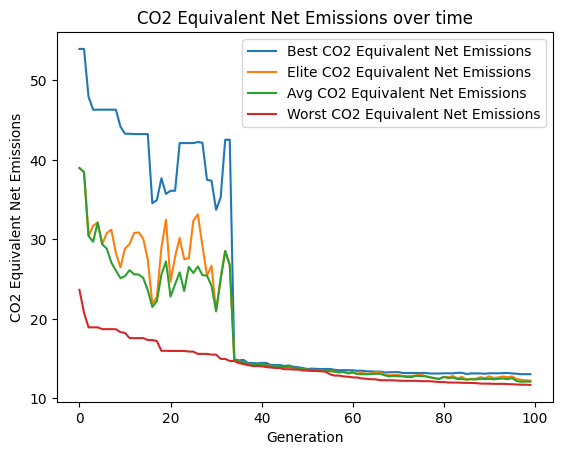

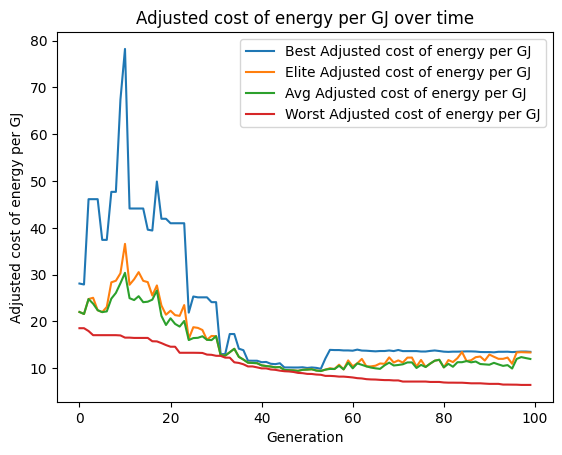

In [171]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(gens):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto[(pareto[outcome] != float("inf")) & (pareto[outcome] != -float("inf"))][outcome]
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.nlargest(n_elites).mean())
    
    # plt.plot(range(gens), [baseline_df[outcome].iloc[-1] for _ in range(gens)], label=f"Baseline {outcome}", color="black")

    plt.plot(range(gens), best, label=f"Best {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Worst {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

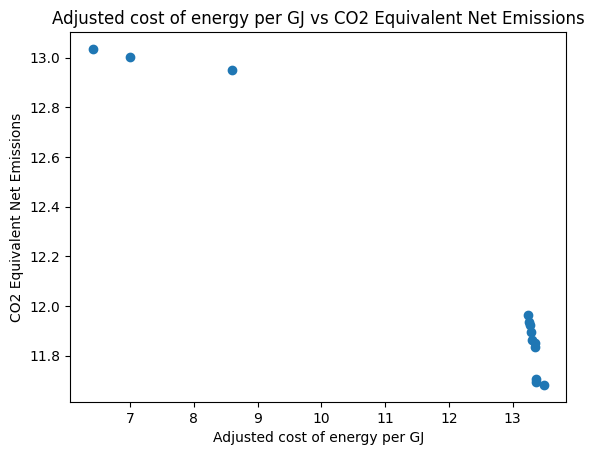

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_39446/222920776.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


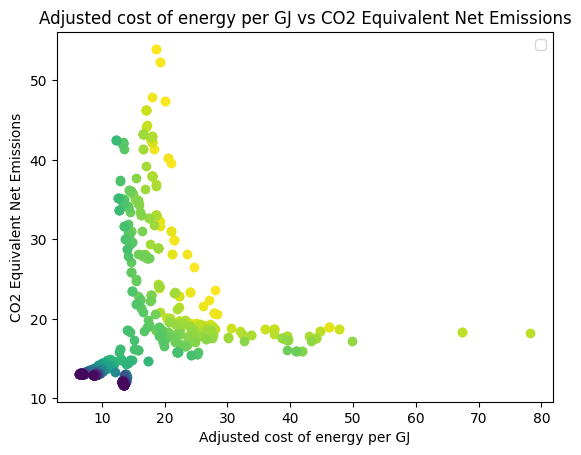

In [172]:
def plot_two_objective(outcome1, outcome2, gens, pareto=True):
    if len(gens) == 1:
        colors = ["C0"]
    else:
        colors = plt.cm.viridis_r([i / (len(gens)+1) for i in range(len(gens)+1)])
    for gen in gens:
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        gen_df = gen_df[gen_df["rank"] == 1] if pareto else gen_df
        gen_df = gen_df[(gen_df[outcome1] != float("inf")) & (gen_df[outcome1] != -float("inf"))]
        plt.scatter(gen_df[outcome1], gen_df[outcome2], color=colors[gens.index(gen)])

    # plt.scatter(baseline_df[outcome1].iloc[-1], baseline_df[outcome2].iloc[-1], color="black", label="Baseline")
    if len(gens) != 1:
        plt.legend()
    plt.title(f"{outcome1} vs {outcome2}")
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_two_objective(outcome_keys[1], outcome_keys[0], [gens])
plot_two_objective(outcome_keys[1], outcome_keys[0], range(gens+1))
#plot_two_objective(outcome_keys[1], outcome_keys[2], [gens])
# plot_two_objective(outcome_keys[0], outcome_keys[2], [gens])
# plot_two_objective(outcome_keys[2], outcome_keys[3], range(gens+1))
# plot_two_objective(outcomes[1], outcomes[0], [1, 25, 50, 100])
# plot_two_objective(outcomes[2], outcomes[1], range(gens+1))
# plot_two_objective(outcomes[2], outcomes[0], range(gens+1))

In [173]:
def get_candidate_actions(candidate: Candidate, torch_context):
    [actions_dict] = candidate.prescribe(torch_context)
    return actions_dict

def get_candidate_from_id(results_dir: Path, cand_id: str):
    cand_path = results_dir / cand_id.split("_")[0] / f"{cand_id}.pt"
    return Candidate.from_seed(cand_path, model_params, actions, outcomes)

In [174]:
best_cand_ids = []
for outcome, ascending in outcomes.items():
    best_cand_ids.append(final_pareto.sort_values(outcome, ascending=ascending).iloc[0]["cand_id"])
    print(final_pareto.sort_values(outcome, ascending=ascending).iloc[0][outcome_keys])
    print()
best_cand_ids = list(set(best_cand_ids))
best_cand_ids

CO2 Equivalent Net Emissions      11.6825
Adjusted cost of energy per GJ     13.487
Name: 1, dtype: object

CO2 Equivalent Net Emissions      13.0346
Adjusted cost of energy per GJ     6.4167
Name: 0, dtype: object



['97_33', '99_26']

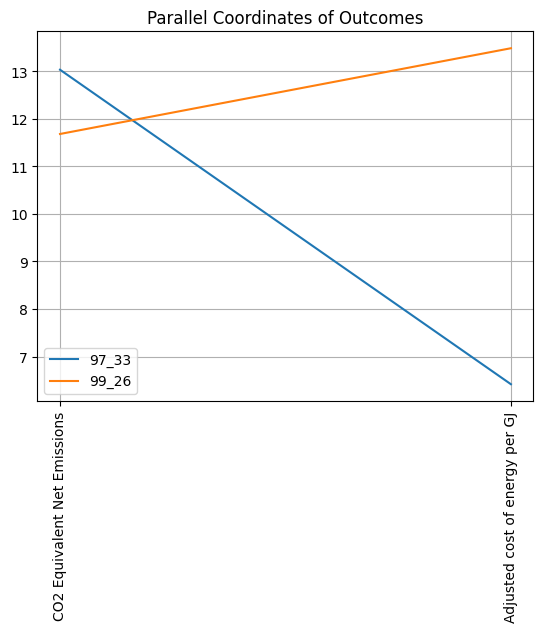

In [175]:
def plot_parallel_coordinates(cand_ids):
    coords = []
    for cand_id in cand_ids:
        gen = int(cand_id.split("_")[0])
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        row = gen_df[gen_df["cand_id"] == cand_id].iloc[0]
        cand_coords = [row[outcome] for outcome in outcomes]
        coords.append(cand_coords)
    
    for cand_coords, cand_id in zip(coords, cand_ids):
        plt.plot(range(len(outcomes)), cand_coords, label=cand_id)
    
    plt.title("Parallel Coordinates of Outcomes")
    plt.xticks(range(len(outcomes)), outcomes.keys(), rotation=90)
    plt.grid()
    plt.legend()
    plt.show()

plot_parallel_coordinates(best_cand_ids)

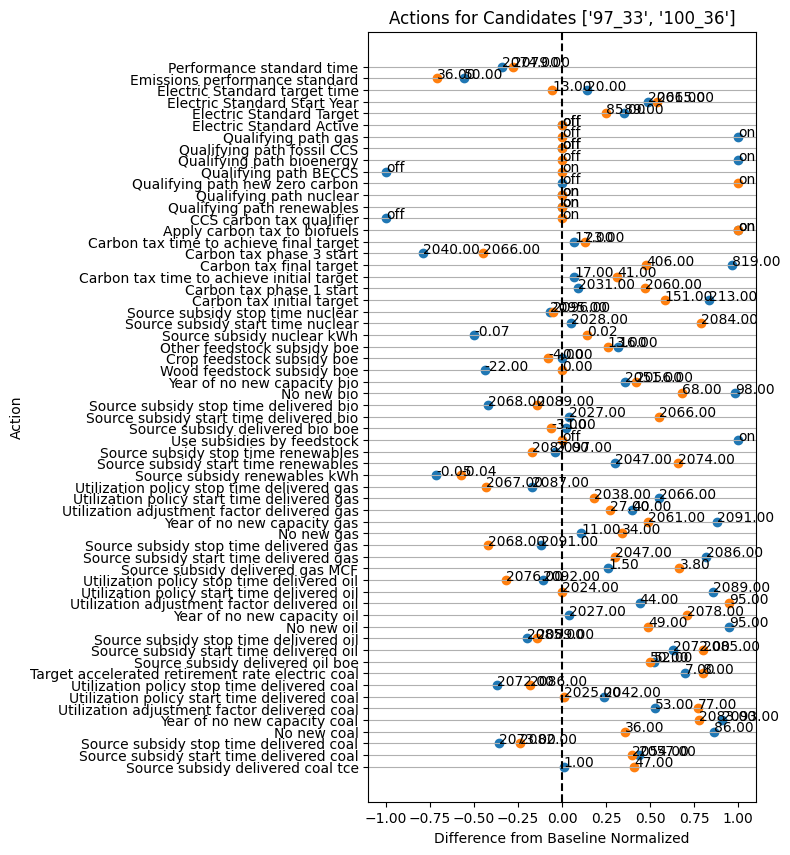

In [176]:
def visualize_action_differences(cand_id1, cand_id2, context_input):
    cand1 = get_candidate_from_id(results_dir, cand_id1)
    cand2 = get_candidate_from_id(results_dir, cand_id2)
    cand1_actions = get_candidate_actions(cand1, context_input)
    cand2_actions = get_candidate_actions(cand2, context_input)
    input_specs = pd.read_json("inputSpecs.jsonl", lines=True)

    fig, ax = plt.subplots(figsize=(5, 10))
    annotations = []
    labels = []
    y_positions = []
    for i, act in enumerate(actions):
        cand1_val = cand1_actions[act]
        cand2_val = cand2_actions[act]
        row = input_specs[input_specs["varId"] == act]
        y_positions.append(i)
        labels.append(input_specs[input_specs["varId"] == act]["varName"].iloc[0])
        if row["kind"].iloc[0] == "slider":
            min_val = input_specs[input_specs["varId"] == act]["minValue"].iloc[0]
            max_val = input_specs[input_specs["varId"] == act]["maxValue"].iloc[0]
            normalized1 = (cand1_val - min_val) / (max_val - min_val)
            normalized2 = (cand2_val - min_val) / (max_val - min_val)
            ax.scatter([normalized1 - normalized2], [i])
            # ax.annotate(f"{cand1_val:.2f} - {cand2_val:.2f}", (normalized1 - normalized2, i))
            annotations.append(f"{cand1_val:.2f} - {cand2_val:.2f}")
        else:
            assert cand1_val == 0 or cand1_val == 1
            assert cand2_val == 0 or cand2_val == 1
            ax.scatter([cand1_val - cand2_val], [i])
            # ax.annotate(f"{cand1_val} - {cand2_val}", (cand1_val - cand2_val, i))
            annotations.append(f"{cand1_val} - {cand2_val}")

    assert len(annotations) == len(labels)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    plt.axvline(0, color="black")
    plt.title(f"{cand_id1} vs. {cand_id2}")
    ax.set_xticks(range(-1, 1))
    plt.ylabel("Action")
    plt.xlabel("Minmax Normalized Value")
    plt.grid(axis="y")
    # plt.tight_layout()
    plt.show()

def visualize_difference_base(results_dirs, cand_ids, context_input):
    fig, ax = plt.subplots(figsize=(5, 10))
    for results_dir, cand_id, color in zip(results_dirs, cand_ids, plt.rcParams['axes.prop_cycle'].by_key()['color']):
        cand = get_candidate_from_id(results_dir, cand_id)
        cand_actions = get_candidate_actions(cand, context_input)
        input_specs = pd.read_json("inputSpecs.jsonl", lines=True)
        i = 0
        for act, val in cand_actions.items():
            row = input_specs[input_specs["varId"] == act]
            baseline_val = row["defaultValue"].iloc[0]
            if row["kind"].iloc[0] == "slider":
                min_val = input_specs[input_specs["varId"] == act]["minValue"].iloc[0]
                max_val = input_specs[input_specs["varId"] == act]["maxValue"].iloc[0]
                assert val >= min_val and val <= max_val
                normalized_y = (val - min_val) / (max_val - min_val)
                normalized_baseline = (baseline_val - min_val) / (max_val - min_val)
                ax.scatter([normalized_y - normalized_baseline], [i], color=color)
                ax.annotate(f"{val:.2f}", (normalized_y - normalized_baseline, i))
            else:
                assert val == 0 or val == 1
                ax.scatter([val - baseline_val], [i], color=color)
                ax.annotate("on" if val == 1 else "off", (val-baseline_val, i))
            
            i += 1

    plt.axvline(0, color="black", linestyle="--")
    ax.set_yticks(range(len(cand_actions)))
    labels = [input_specs[input_specs["varId"] == act]["varName"].iloc[0] for act in cand_actions.keys()]
    ax.set_yticklabels(labels)
    plt.title(f"Actions for Candidates {cand_ids}")
    plt.ylabel("Action")
    plt.xlabel("Difference from Baseline Normalized")
    plt.grid(axis="y")
    plt.show()

[context_input] = next(iter(evaluator.torch_context), None)

visualize_difference_base([results_dir, Path("results/context/movetruncate")], [best_cand_ids[0], "100_36"], context_input)

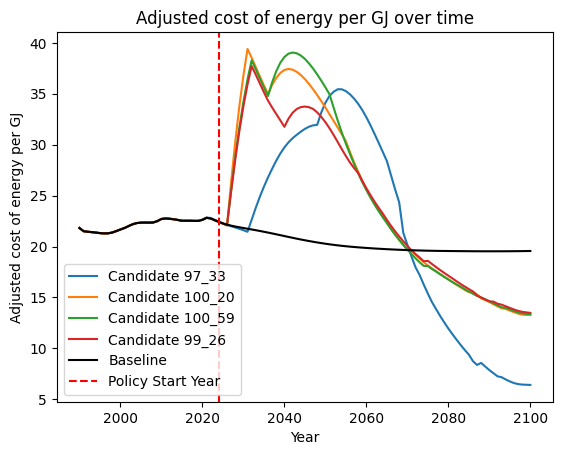

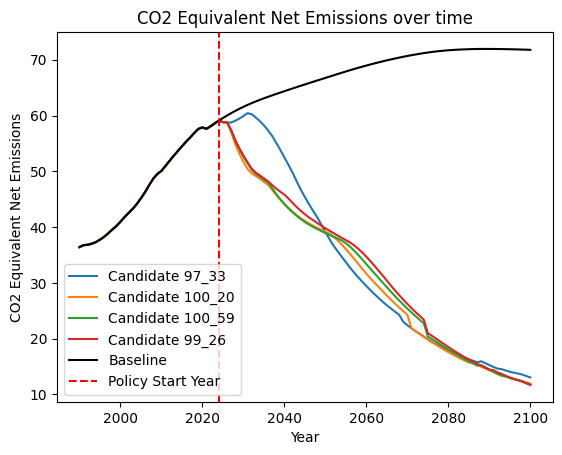

In [179]:
def plot_outcome_over_time(outcome, cand_ids):
    for cand_id in cand_ids:
        cand = get_candidate_from_id(results_dir, cand_id)
        cand_outcomes = evaluator.evaluate_candidate(cand)
        plt.plot(range(1990, 2101), cand_outcomes[outcome], label=f"Candidate {cand_id}")
    plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
    plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")
    plt.legend()
    plt.title(f"{outcome} over time")
    plt.xlabel("Year")
    plt.ylabel(outcome)
    plt.show()

cand_ids = list(final_pareto.sort_values(outcome_keys[1])["cand_id"])
cand_ids = [cand_ids[i] for i in [0, 5, 10, -1]]
for outcome in enroads_outcomes:
    plot_outcome_over_time(outcome, cand_ids)

In [ ]:
def plot_energy_usage(cand_ids):
    fig, axes = plt.subplots(1, len(cand_ids), sharey=True, figsize=(15, 5))
    if len(cand_ids) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_ids, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            cand = get_candidate_from_id(results_dir, cand_id)
            cand_outcomes = evaluator.evaluate_candidate(cand)
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [f"Primary energy demand of {energy}" for energy in energies]
        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        ax.set_title(f"Candidate {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    plt.legend()
    plt.show()

In [ ]:
def plot_energy_difference(cand_id):
    colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
    energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
    demands = [f"Primary energy demand of {energy}" for energy in energies]

    cand = get_candidate_from_id(results_dir, cand_id)
    cand_outcomes = evaluator.evaluate_candidate(cand)
    energy_df = cand_outcomes[demands]

    energy_baseline = baseline_df[demands]

    diff_df = energy_df - energy_baseline
    plt.grid(axis="y")
    plt.bar(energies, diff_df.iloc[-1], color=colors)
    plt.ylabel("Difference in Energy (Exajoules / year)")
    plt.xlabel("Energy Source")
    plt.title(f"Difference in Energy from Baseline for {cand_id} in 2100")
    plt.xticks(rotation=90)
    plt.show()

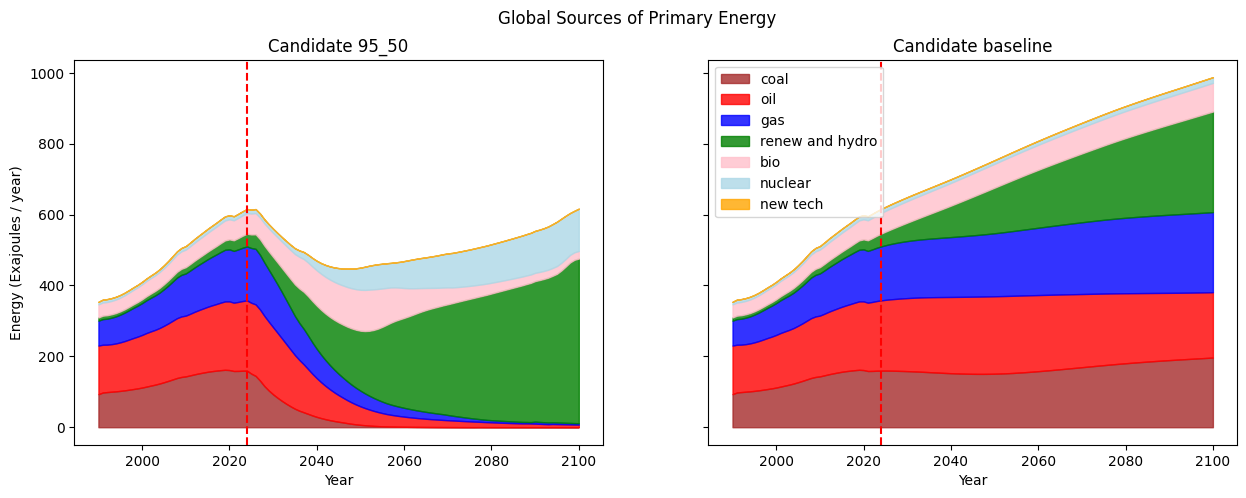

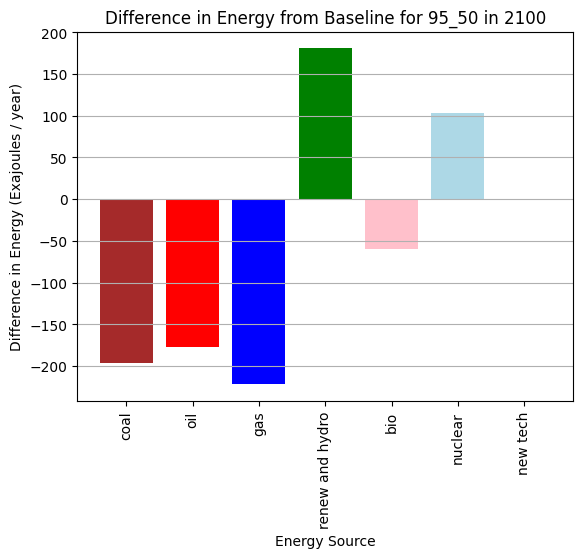

In [ ]:
examine = "95_50"
plot_energy_usage([examine, "baseline"])
plot_energy_difference(examine)

In [ ]:
open_browser(results_dir, examine)

make: `enroads' is up to date.
